# Figures S4 and S5: Denmark Strait basin timeseries and correlations between pressure differences and wind stress

This notebook will reproduce Figures S4 and S5 from  E. Boland et al. 2026 (doi to come). This requires input datafiles from the ECCOv4 solution - please see the README for details.

The datafiles were created as follows:
- m_horflux_fw_denm.0000000129.data and m_horflux_vol_denm.0000000129.data found in {DATA_DIR}, are generated by running the ECCOv4r4 solution using the masks DenmarkStrait_mask* generated using generate_masks.py and modified code found in https://doi.org/10.5281/zenodo.17225253

Please attribute any plots or code from this notebook using the DOI from Zenodo: https://doi.org/10.5281/zenodo.17225514

E Boland Jan 2026 [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [6]:
import xarray as xr
import sys
sys.path.insert(0,'/users/emmomp/Python/ECCOv4-py')
import ecco_v4_py as ecco
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
import utils as ut
import cartopy.crs as ccrs
from inputs import ecco_grid, SOLN_DIR, DATA_DIR
import warnings
warnings.filterwarnings('ignore')

In [2]:
ds= ecco.recursive_load_ecco_var_from_years_nc(SOLN_DIR, \
                                           vars_to_load=['OBP','SSH','oceTAUX','oceTAUY'],\
                                           years_to_load = 'all')

loading files of  OBP
loading files of  SSH
loading files of  oceTAUX
loading files of  oceTAUY


In [3]:
grid= ecco.get_llc_grid(ecco_grid)
ds['oceTAUU'],ds['oceTAUV']=ecco.vector_calc.UEVNfromUXVY(ds.oceTAUX.load(),ds.oceTAUY.load(),ecco_grid,grid=grid)

In [5]:
vol=ut.get_soln('horflux_vol_denm',f'{DATA_DIR}')
fw=ut.get_soln('horflux_fw_denm',f'{DATA_DIR}')

read_llc_to_tiles: full_filename:  ../data_out/m_horflux_vol_denm.0000000129.data
read_llc_to_tiles: full_filename:  ../data_out/m_horflux_fw_denm.0000000129.data


In [5]:
section='Denmark Strait'
[section_pt1,section_pt2]=ecco.get_section_endpoints(section)
line_maskC,_,_ = ecco.get_section_line_masks(section_pt1,section_pt2,ecco_grid)
strait_ds=ds.where(line_maskC,drop=True).squeeze().stack({'ij':['j','i']}).swap_dims({'ij':'XC'}).sortby('XC').dropna('XC',how='all')
delta_ds=(strait_ds.isel(XC=10)-strait_ds.isel(XC=1))

In [6]:
fw_anom,_=ut.soln_anoms(fw)
vol_anom,_=ut.soln_anoms(vol)
obp_anom,_=ut.soln_anoms(delta_ds.OBP)
ssh_anom,_=ut.soln_anoms(delta_ds.SSH)

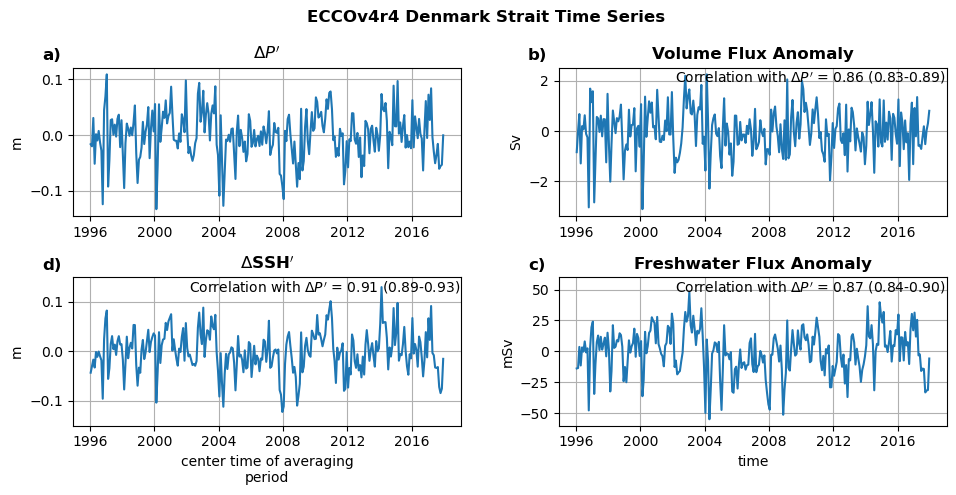

In [7]:
plt.figure(figsize=[10,5])
ax1=plt.subplot(2,2,1)
obp_anom.plot()
plt.ylabel('m')
plt.title("$\Delta P'$",fontweight='bold')
plt.xlabel('')
ax1.grid()
plt.text(-0.08,1.05,'a)',transform=ax1.transAxes,fontsize=12,fontweight='bold')
ax2=plt.subplot(2,2,2)
ax2.sharex(ax1)
(vol_anom/1e6).plot()
rs=stats.pearsonr(obp_anom,vol_anom)
plt.text(0.3,0.9,f"Correlation with $\Delta P'$ = {rs.statistic:2.2f} ({rs.confidence_interval().low:2.2f}-{rs.confidence_interval().high:2.2f})",transform=ax2.transAxes)
plt.ylabel('Sv')
plt.text(-0.08,1.05,'b)',transform=ax2.transAxes,fontsize=12,fontweight='bold')
plt.xlabel('')
ax2.grid()
plt.title("Volume Flux Anomaly",fontweight='bold')
ax3=plt.subplot(2,2,4)
ax3.sharex(ax1)
(fw_anom/1e3).plot()
rs=stats.pearsonr(obp_anom,fw_anom)
plt.text(0.3,0.9,f"Correlation with $\Delta P'$ = {rs.statistic:2.2f} ({rs.confidence_interval().low:2.2f}-{rs.confidence_interval().high:2.2f})",transform=ax3.transAxes)
plt.ylabel('mSv')
ax3.grid()
plt.ylim([-60,60])
plt.text(-0.08,1.05,'c)',transform=ax3.transAxes,fontsize=12,fontweight='bold')
plt.title("Freshwater Flux Anomaly",fontweight='bold')
ax4=plt.subplot(2,2,3)
ax4.sharex(ax1)
ssh_anom.plot()
rs=stats.pearsonr(obp_anom,ssh_anom)
plt.text(0.3,0.9,f"Correlation with $\Delta P'$ = {rs.statistic:2.2f} ({rs.confidence_interval().low:2.2f}-{rs.confidence_interval().high:2.2f})",transform=ax4.transAxes)
plt.ylabel('m')
plt.title("$\Delta$SSH$'$",fontweight='bold')
ax4.grid()
plt.ylim([-0.15,0.15])
plt.text(-0.08,1.05,'d)',transform=ax4.transAxes,fontsize=12,fontweight='bold')
plt.suptitle('ECCOv4r4 Denmark Strait Time Series',fontweight='bold')
plt.tight_layout()
plt.savefig('../plots/figS4_PresSSHfluxes.pdf')

In [8]:
# Create mask surrounding Greenland to carry out correlation calculation
GL_mask=(ecco_grid.XC>-60)&(ecco_grid.XC<-0)&(ecco_grid.YC<85)&(ecco_grid.YC>55)
ds_gl=ds.where(GL_mask,drop=True)

In [9]:
stats_comb=[]
for ovar in ['oceTAUU','oceTAUV']:
    pp=xr.zeros_like(ds_gl[ovar].isel(time=0))
    rr=xr.zeros_like(pp)
    rr_down=xr.zeros_like(pp)
    rr_up=xr.zeros_like(pp)
    for it in range(0,ds_gl.tile.size):
        for ij in range(0,ds_gl.j.size):
            for ii in range(0,ds_gl.i.size):
                YY=ds_gl[ovar][:,it,ij,ii]
                if any(YY.isnull()):
                    continue
                YY_anom,_=ut.soln_anoms(YY)
                stats_out=stats.pearsonr(obp_anom,YY_anom)
                pp[it,ij,ii]=stats_out.pvalue
                rr[it,ij,ii]=stats_out.statistic
                rr_down[it,ij,ii]=stats_out.confidence_interval().low
                rr_up[it,ij,ii]=stats_out.confidence_interval().high
    rr.name='R'
    rr_up.name='R_up'
    rr_down.name='R_do'
    pp.name='p'
    all_stats=xr.merge([rr,rr_up,rr_down,pp])
    stats_comb.append(all_stats.assign_coords({'ovar':ovar}))
stats_comb=xr.concat(stats_comb,'ovar')
stats_comb

<xarray.Dataset> Size: 290kB
Dimensions:   (ovar: 2, tile: 3, j: 43, i: 40)
Coordinates:
  * j         (j) int64 344B 47 48 49 50 51 52 53 54 ... 82 83 84 85 86 87 88 89
  * i         (i) int64 320B 0 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38 39
  * tile      (tile) int64 24B 2 6 10
    XC        (tile, j, i) float32 21kB -37.5 -36.5 -35.5 ... -38.5 -38.5 -38.5
    YC        (tile, j, i) float32 21kB 49.75 49.75 49.75 ... 52.81 52.22 51.61
    timestep  int64 8B 732
    time      datetime64[ns] 8B 1992-01-16T12:00:00
    CS        (tile, j, i) float32 21kB 1.0 1.0 1.0 ... -1.168e-14 -0.0
    SN        (tile, j, i) float32 21kB -5.534e-15 1.653e-14 ... -1.0 -1.0
    Depth     (tile, j, i) float32 21kB 4.167e+03 4.082e+03 ... 3.613e+03
    rA        (tile, j, i) float32 21kB 5.084e+09 5.084e+09 ... 4.675e+09
  * ovar      (ovar) <U7 56B 'oceTAUU' 'oceTAUV'
Data variables:
    R         (ovar, tile, j, i) float32 41kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    R_up      (ovar, tile, j, i) float32 41kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    R_do      (ovar, tile, j, i) float32 41kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    p         (ovar, tile, j, i) float32 41kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [27]:
stats_comb=stats_comb.load()
stats_comb['p']=xr.where(stats_comb.R==0,np.nan,stats_comb.p)
stats_comb['R']=xr.where(stats_comb.R==0,np.nan,stats_comb.R)

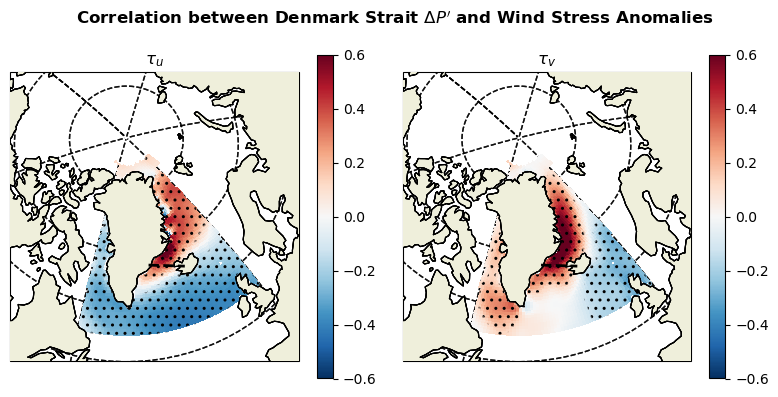

In [32]:
xmin,xmax,ymin,ymax=(-2266791.253073855,
 3358349.2597455736,
 -2166791.253073855,
 3458349.2597455736)
my_projn = ccrs.Orthographic(central_longitude=-45,central_latitude=70)
proj_dict={'projection_type':'ortho','user_lon_0':-45,'user_lat_0':70}
plt.figure(figsize=[8,4])
[f,ax,p]=ut.plot_ecco(stats_comb,stats_comb.R.sel(ovar='oceTAUU'),**proj_dict,subplot_grid=[1,2,1],cmin=-0.6,cmax=0.6,rasterized=True)
[f,ax,p]=ut.plot_ecco(stats_comb,(stats_comb.p.sel(ovar='oceTAUU')<=0.05).astype('int'),**proj_dict,plot_type='contourf',cmap=None,
                      hatches=['','..'],alpha=0,ax=ax,show_colorbar=False,rasterized=True)
ax.set_extent([xmin,xmax,ymin,ymax], crs=my_projn)        
ax.plot([section_pt1[0],section_pt2[0]],[section_pt1[1],section_pt2[1]],ls='--',
             color='k', linewidth=2,transform=ccrs.PlateCarree(),zorder=1000)
plt.title('$\\tau_u$',fontweight='bold')
[f,ax,p]=ut.plot_ecco(stats_comb,stats_comb.R.sel(ovar='oceTAUV'),**proj_dict,subplot_grid=[1,2,2],cmin=-0.6,cmax=0.6,rasterized=True)
[f,ax,p]=ut.plot_ecco(stats_comb,(stats_comb.p.sel(ovar='oceTAUV')<=0.05).astype('int'),**proj_dict,plot_type='contourf',cmap=None,
                      hatches=['','..'],alpha=0,ax=ax,show_colorbar=False,rasterized=True)
ax.set_extent([xmin,xmax,ymin,ymax], crs=my_projn)
ax.plot([section_pt1[0],section_pt2[0]],[section_pt1[1],section_pt2[1]],ls='--',
             color='k', linewidth=2,transform=ccrs.PlateCarree(),zorder=1000)
plt.title('$\\tau_v$',fontweight='bold')
plt.suptitle("Correlation between Denmark Strait $\Delta P'$ and Wind Stress Anomalies",fontweight='bold')
plt.tight_layout()
plt.savefig('../plots/figS5_presVwindstress.pdf')